In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from numba import njit
import re

# Numba-jitted function to calculate 'mentioned_together'
@njit
def calculate_mentioned_together(ballots, Ncand, numballots, numranks):
    mentioned_together = np.zeros((Ncand, Ncand))
    for i in range(numballots):
        for j in range(numranks):
            for k in range(numranks):
                if ballots[i, j] <= Ncand and ballots[i, k] <= Ncand:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together

# Main RCV analysis function
def rcv_analysis(csv_file, ignore_patterns=['^WRITE-IN', '^writein', '^write in', '^Write-In', '^Write-in', '^skipped', '^overvote', '^uncommited'], metric=True):
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')
    
    # Create a combined regex pattern
    combined_pattern = '|'.join(ignore_patterns)

    # Apply the regex to filter out rows that match the ignore patterns
    for column in df.columns:
        df[column] = df[column].astype(str)
        df[column] = df[column].apply(lambda x: np.nan if re.match(combined_pattern, x) else x)

    df.dropna(inplace=True)
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    le = LabelEncoder()
    le.fit(names)
    ballots = [le.transform(ballot) for ballot in raw_ballots]
    names = le.classes_
    Ncand = len(names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    numballots, numranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((Ncand, Ncand))
    for i in range(numballots):
        for j in range(numranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, Ncand, numballots, numranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    freq = counts / mentioned_together

    # Combine freq in either direction to create symmetric matrix
    freq_upptri = np.zeros((Ncand, Ncand))
    for i in range(Ncand):
        for j in range(i+1, Ncand):
            freq_upptri[i, j] = (freq[i, j] + freq[j, i]) / 2
            freq_upptri[j, i] = freq_upptri[i, j]

    # Compute 'd' (distance metric)
    foo = np.min(freq_upptri[freq_upptri > 0])
    d = 1 / np.sqrt(freq_upptri)
    d[np.isnan(d)] = 2 / foo
    d[np.isinf(d)] = 2 / foo
    np.fill_diagonal(d, 0)

    # Perform nonmetric MDS for 1 dimension
    mds = MDS(n_components=1, metric=metric, dissimilarity='precomputed', random_state=0)
    YY = mds.fit_transform(d)

    # Perform nonmetric MDS for 2 dimensions
    mds = MDS(n_components=2, metric=metric, dissimilarity='precomputed', random_state=0)
    Y = mds.fit_transform(d)

    # Return the results
    return {
        "election": csv_file, 
        "names": names, 
        "1d_mds": YY, 
        "2d_mds": Y
    }

In [44]:
# Function to iterate over all rows in the metadata DataFrame
def iterate_over_metadata(metadata_df):
    results = []
    base_dir = 'rcv_elections_database'
    for idx, row in metadata_df.iterrows():
        if row['file_exists']:
            csv_file = f"{base_dir}/{row['sub_dir_path']}/{row['filename']}"
            try:
                result = rcv_analysis(csv_file)
                result['race_id'] = row['race_id']
                results.append(result)
            except Exception as e:
                print(f"Error processing file {csv_file}: {e}")
    return results

In [45]:
# Read MatchedMetadata.csv
metadata_df = pd.read_csv('rcv_elections_database/MatchedMetadata.csv')

# Paths to the directories
dir_paths = ['rcv_elections_database/proportional', 
             'rcv_elections_database/single', 
             'rcv_elections_database/sequential']

# Initialize a list to hold the file names
file_names = []

# Iterate over the directories and get the file names
for dir_path in dir_paths:
    for file_name in os.listdir(dir_path):
        file_names.append(file_name)

# Count how many files from the metadata are in the directories
metadata_df['file_exists'] = metadata_df['filename'].isin(file_names)

# Display the first few rows of the DataFrame
metadata_df.head()

,main_dir_path,sub_dir_path,filename,race_id,score,file_exists
0,team_arrow/rcv_elections_database,proportional,Cambridge_11032009_CityCouncil.csv,Cambridge_11032009_CityCouncil_tab1,92,True
1,team_arrow/rcv_elections_database,proportional,Cambridge_11032015_CityCouncil.csv,Cambridge_11032015_CityCouncil_tab1,92,True
2,team_arrow/rcv_elections_database,proportional,Cambridge_11032015_SchoolCommittee.csv,Cambridge_11032015_SchoolCommittee_tab1,93,True
3,team_arrow/rcv_elections_database,proportional,Cambridge_11042003_CityCouncil.csv,Cambridge_11042003_CityCouncil_tab1,92,True
4,team_arrow/rcv_elections_database,proportional,Cambridge_11042003_SchoolCommittee.csv,Cambridge_11042003_SchoolCommittee_tab1,93,True


In [36]:
# Count the number of existing and non-existing files
file_exists_counts = metadata_df['file_exists'].value_counts()

file_exists_counts

True    486
Name: file_exists, dtype: int64

In [46]:
# Run the function on the metadata DataFrame
results = iterate_over_metadata(metadata_df)

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/sequential/Payson_11052019_CityCouncil_tab1.csv: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 2d, C), UniTuple(float64 x 2))
 
There are 22 candidate implementations:
    - Of which 20 did not match due to:
    Overload of function 'getitem': File: <numerous>: Line N/A.
      With argument(s): '(array(float64, 2d, C), UniTuple(float64 x 2))':
     No match.
    - Of which 2 did not match due to:
    Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 209.
      With argument(s): '(array(float64, 2d, C), UniTuple(float64 x 2))':
     Rejected as the implementation raised a specific error:
       NumbaTypeError: Unsupported array index type float64 in UniTuple(float64 x 2)
  raised from c:\Python310\lib\site-packages\numba\core\typing\arraydecl.py:102

During: typing of intrin

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: invalid value encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: invalid value encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_up

Error processing file rcv_elections_database/sequential/Vineyard_11052019_CityCouncil_tab1.csv: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 2d, C), UniTuple(float64 x 2))
 
There are 22 candidate implementations:
    - Of which 20 did not match due to:
    Overload of function 'getitem': File: <numerous>: Line N/A.
      With argument(s): '(array(float64, 2d, C), UniTuple(float64 x 2))':
     No match.
    - Of which 2 did not match due to:
    Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 209.
      With argument(s): '(array(float64, 2d, C), UniTuple(float64 x 2))':
     Rejected as the implementation raised a specific error:
       NumbaTypeError: Unsupported array index type float64 in UniTuple(float64 x 2)
  raised from c:\Python310\lib\site-packages\numba\core\typing\arraydecl.py:102

During: typing of intr

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Alaska_11082022_HouseDistrict3.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/Alaska_11082022_HouseDistrict33.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\U

Error processing file rcv_elections_database/single/Alaska_11082022_HouseDistrict37.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/Alaska_11082022_HouseDistrict38.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/Alaska_11082022_HouseDistrict40.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/Alaska_11082022_HouseDistrict8.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/Alaska_11082022_SenateDistrictB.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Berkeley_11022010_CityAuditor.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Berkeley_11042014_CityAuditor.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Burlington_03072023_CityCouncilEastDistrict.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/Burlington_03072023_CityCouncilNorthDistrict.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/Easthampton_11022021_Mayor.csv: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 2d, C), UniTuple(float64 x 2))
 
There are 22 candidate implementations:
    - Of which 20 did not match due to:
    Overload of function 'getitem': File: <numerous>: Line N/A.
      With argument(s): '(array(float64, 2d, C), UniTuple(float64 x 2))':
     No match.
    - Of which 2 did not match due to:
    Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 209.
      With argument(s): '(array(float64, 2d, C), UniTuple(float64 x 2))':
     Rejected as the implementation raised a specific error:
       NumbaTypeError: Unsupported array index type float64 in UniTuple(float64 x 2)
  raised from c:\Python310\lib\site-packages\numba\core\typing\arraydecl.py:102

During: typing of intrinsic-call a

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Minneapolis_11022021_ParkBoardDistrict1.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\E

Error processing file rcv_elections_database/single/Minneapolis_11062009_PRBoardDistrict2.csv: not enough values to unpack (expected 2, got 1)
Error processing file rcv_elections_database/single/Minneapolis_11062009_PRBoardDistrict3.csv: not enough values to unpack (expected 2, got 1)
Error processing file rcv_elections_database/single/Minneapolis_11062009_PRBoardDistrict4.csv: not enough values to unpack (expected 2, got 1)


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Minneapolis_11062009_Ward2CityCouncil.csv: not enough values to unpack (expected 2, got 1)


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\E

Error processing file rcv_elections_database/single/Minneapolis_11072017_Ward2CityCouncil.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Oakland_11022010_SchoolDirectorDistrict2.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/Oakland_11022010_SchoolDirectorDistrict6.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Oakland_11062018_SchoolDirectorDistrict2.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/Oakland_11082016_CityAttorney.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/Oakland_11082022_CityAuditor.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/SanFrancisco_11032020_BOARDOFSUPERVISORSDISTRICT9.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/SanFrancisco_11052019_CityAttorney.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/SanFrancisco_11052019_PublicDefender.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/SanFrancisco_11052019_Sheriff.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/SanFrancisco_11052019_Treasurer.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/SanFrancisco_11062018_PublicDefender.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/SanFrancisco_11072006_BoardofSupervisorsDistrict2.csv: not enough values to unpack (expected 2, got 1)


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/SanFrancisco_11082022_AssessorRecorder.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/SanFrancisco_11082022_BoardofSupervisorsD2.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/SanLeandro_11022010_CountyCouncilDistrict3.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


Error processing file rcv_elections_database/single/SanLeandro_11032020_MemberCityCouncilDist6SanLeandroRCV.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/SanLeandro_11082016_CountyCouncilDistrict4.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/SanLeandro_11082016_CountyCouncilDistrict6.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Si

Error processing file rcv_elections_database/single/StLouisPark_11022021_CityCouncilWard1.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/StLouisPark_11022021_CityCouncilWard4.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/TakomaPark_11082022_CityCouncilWard1.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/TakomaPark_11082022_CityCouncilWard2.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/TakomaPark_11082022_CityCouncilWard3.csv: zero-size array to reduction operation minimum which has no identity
Error processing file rcv_elections_database/single/TakomaPark_11082022_CityCouncilWard4.csv: zero-size array to reduction operation minimum which has no identity


C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: divide by zero encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:66: RuntimeWarning: invalid value encountered in true_divide
  freq = counts / mentioned_together
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_24116\3327057866.py:77: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)
C:\Us

In [48]:
for result in results:
    print(result['2d_mds'])

[[  4.73640493   2.41144023]
 [  2.70755866   1.85429418]
 [  0.18097661   0.25542488]
 [-11.1200693    2.04782931]
 [  4.95620102   0.50540013]
 [  4.60278155  -1.25807463]
 [  2.00184561  -0.74791044]
 [  3.56951137  -2.70876156]
 [ -0.81042577  -2.41349367]
 [  1.95587733  -3.84471362]
 [  1.39983416  -5.19670424]
 [ -0.0334626   -4.27674925]
 [ -3.3325684   -1.60594094]
 [ -2.37372963  -2.09933248]
 [ -4.11881706  -0.22492826]
 [ -2.20392568   0.71929694]
 [ -1.63971534   2.25362652]
 [ -2.71983785   2.62396529]
 [  0.2246366    3.52928997]
 [  2.52215642   4.31798754]
 [ -0.50523265   3.85805407]]
[[-3.25355288  5.85396131]
 [-3.61666737  3.30055336]
 [-2.72552213  3.68719176]
 [-4.14792156  0.18021729]
 [-4.41346393 -3.29954982]
 [-3.71817369 -3.74353418]
 [-2.90344686 -6.01897962]
 [-1.55451433 -3.79087504]
 [ 0.0172031  -6.16201177]
 [ 0.51694344  2.31543261]
 [ 1.6784848  -3.5975993 ]
 [ 3.49228779  4.99719647]
 [ 3.87230579 -1.01442952]
 [ 3.08269298  2.28184783]
 [ 3.9662006

In [56]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

# Perform KMeans clustering on each result
for result in results:
    YY = result['1d_mds']
    Y = result['2d_mds']

    # Perform KMeans clustering on 1D MDS data
    kmeans_1d = KMeans(n_clusters=2)
    kmeans_1d.fit(YY.reshape(-1, 1))
    centroid1_1d, centroid2_1d = kmeans_1d.cluster_centers_
    inter_centroid_distance_1d = euclidean(centroid1_1d, centroid2_1d)
    result['kmeans_1d_labels'] = kmeans_1d.labels_

    # Perform KMeans clustering on 2D MDS data
    kmeans_2d = KMeans(n_clusters=2)
    kmeans_2d.fit(Y)
    centroid1_2d, centroid2_2d = kmeans_2d.cluster_centers_
    inter_centroid_distance_2d = euclidean(centroid1_2d, centroid2_2d)
    result['kmeans_2d_labels'] = kmeans_2d.labels_

    # Store the inter-centroid distances in the result dictionary
    result['inter_centroid_distance_1d'] = inter_centroid_distance_1d
    result['inter_centroid_distance_2d'] = inter_centroid_distance_2d

# Sort the results list by the 1D inter-centroid distance
results.sort(key=lambda x: x['inter_centroid_distance_1d'])

1D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11062009_Ward10CityCouncil.csv: 1.7226544661716856


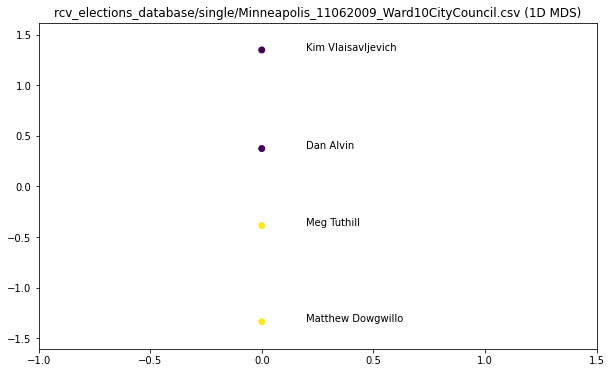

2D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11062009_Ward10CityCouncil.csv: 1.4681819944222982


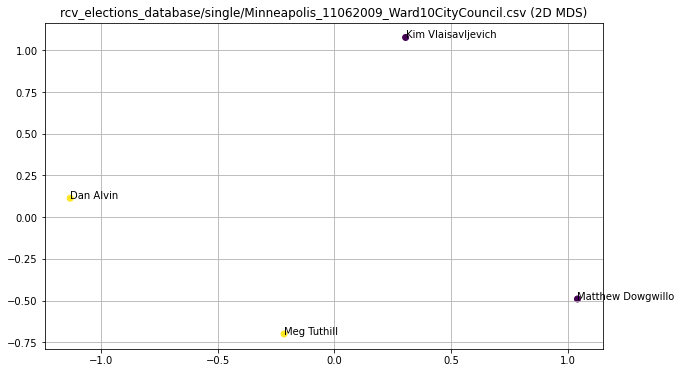

1D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11022021_CityCouncilWard4.csv: 1.7415703603158041


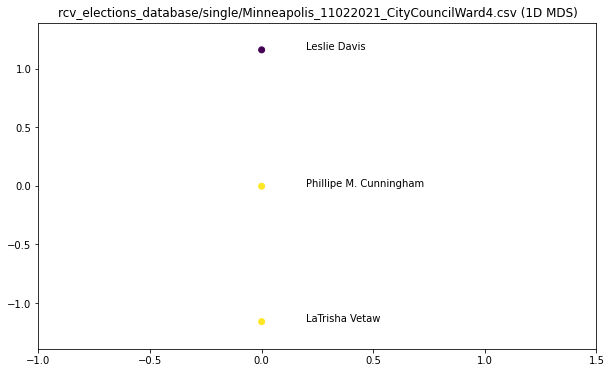

2D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11022021_CityCouncilWard4.csv: 1.5203957469200566


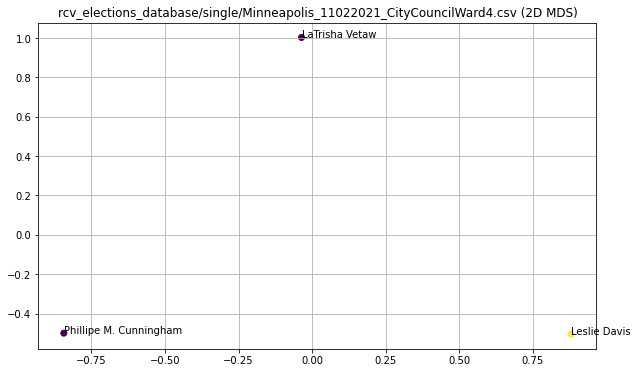

1D Inter-centroid distance for rcv_elections_database/single/Oakland_11062012_CityCouncilDistrict5.csv: 1.7424384253125669


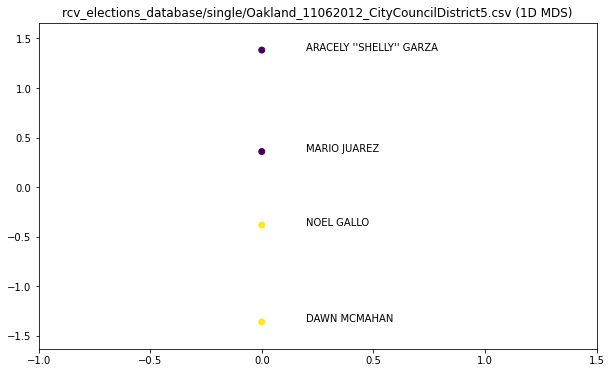

2D Inter-centroid distance for rcv_elections_database/single/Oakland_11062012_CityCouncilDistrict5.csv: 1.428778852197036


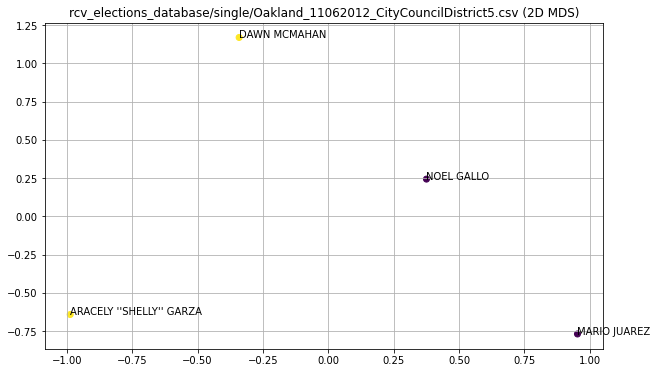

1D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_RepublicanCandidateforUSHouseofRepresentativesDistrict2.csv: 1.743795909673595


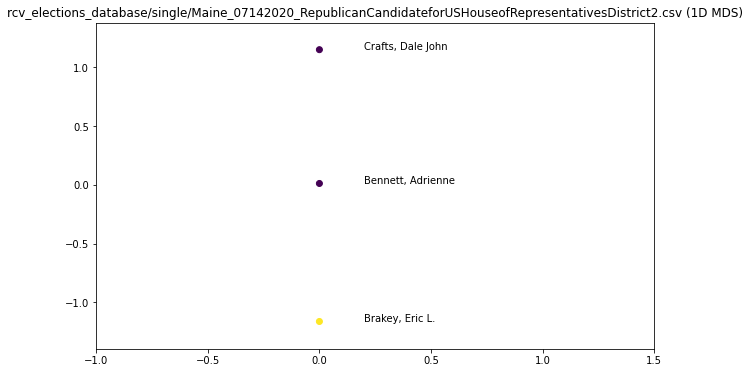

2D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_RepublicanCandidateforUSHouseofRepresentativesDistrict2.csv: 1.5249019092998481


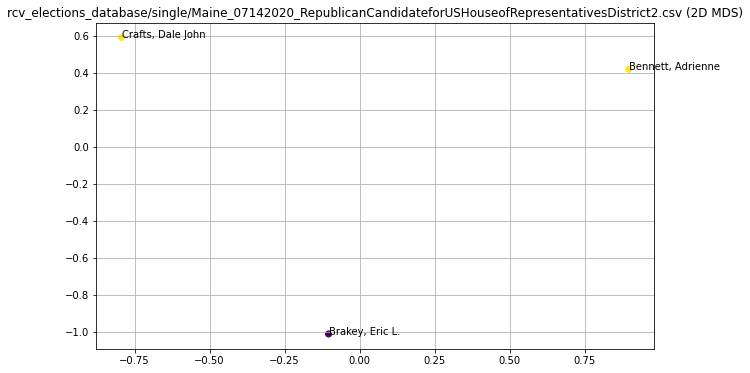

1D Inter-centroid distance for rcv_elections_database/single/Oakland_11062012_SchoolDirectorDistrict3.csv: 1.7450069501498182


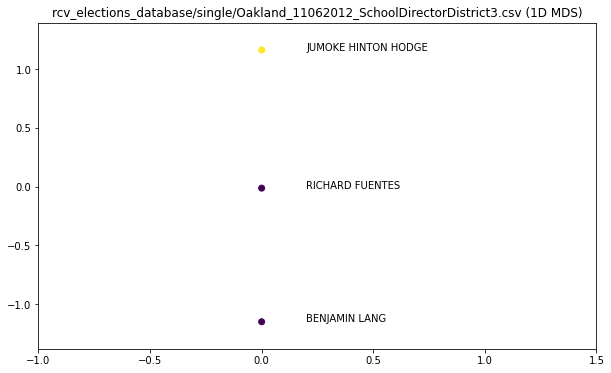

2D Inter-centroid distance for rcv_elections_database/single/Oakland_11062012_SchoolDirectorDistrict3.csv: 1.5317753266854435


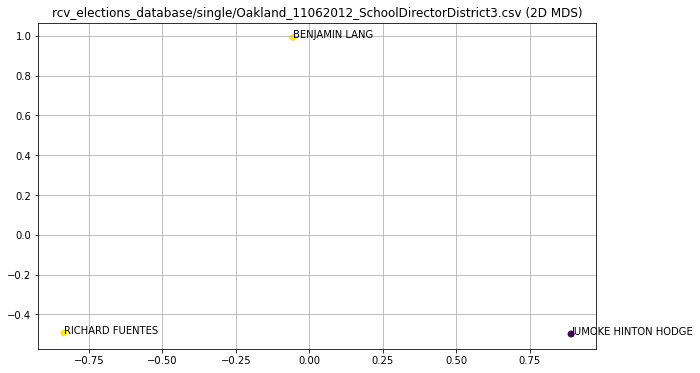

1D Inter-centroid distance for rcv_elections_database/single/StLouisPark_11022021_CityCouncilWard3.csv: 1.745763349199644


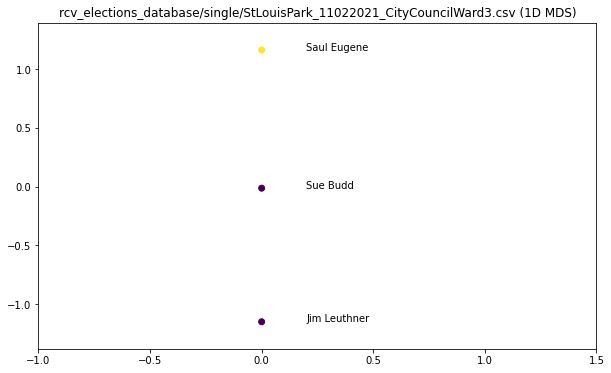

2D Inter-centroid distance for rcv_elections_database/single/StLouisPark_11022021_CityCouncilWard3.csv: 1.5292969482214167


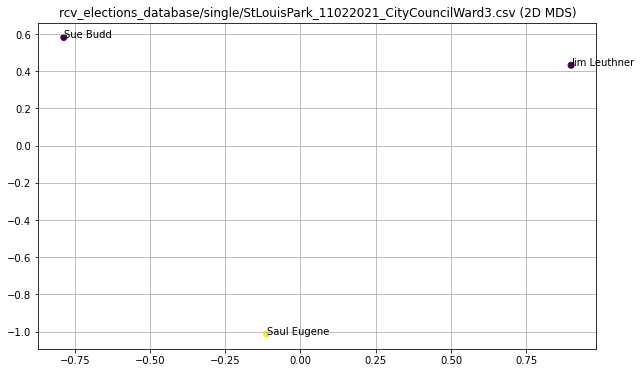

1D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateSenateDistrict11.csv: 1.745895659347167


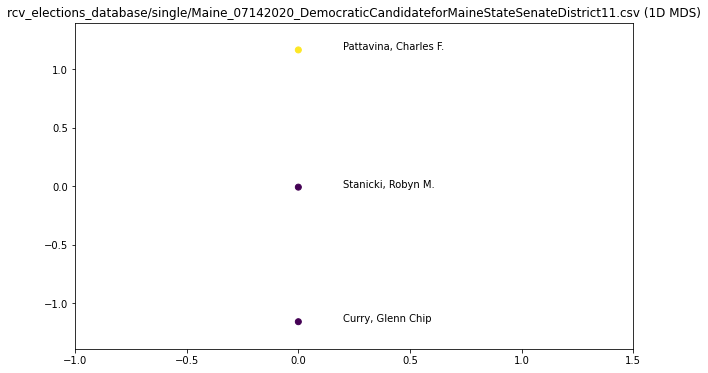

2D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateSenateDistrict11.csv: 1.526272510231055


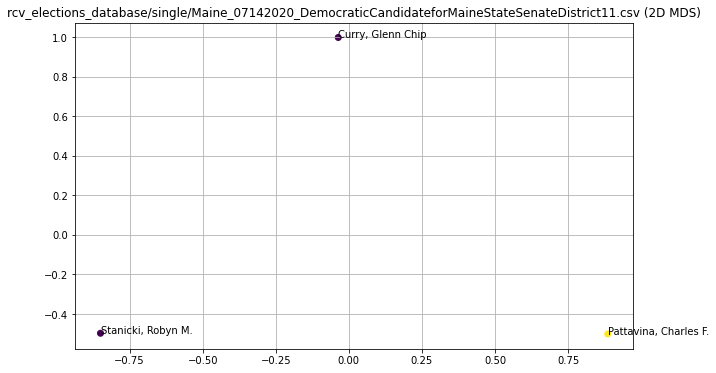

1D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11072017_Ward3CityCouncil.csv: 1.7472949403878246


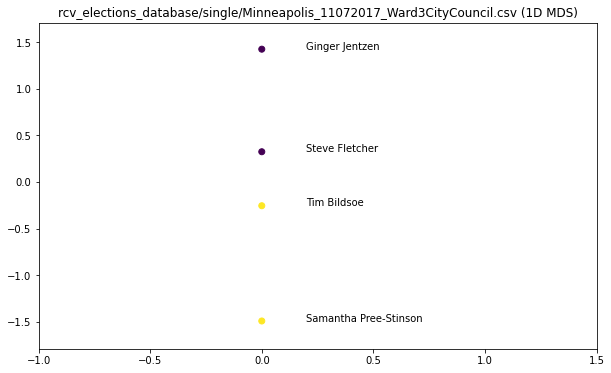

2D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11072017_Ward3CityCouncil.csv: 1.4920359231764857


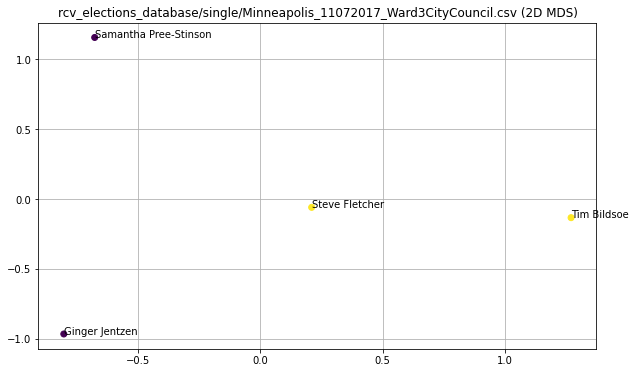

1D Inter-centroid distance for rcv_elections_database/single/Corvallis_11082022_CityCouncilWard9.csv: 1.748386886381233


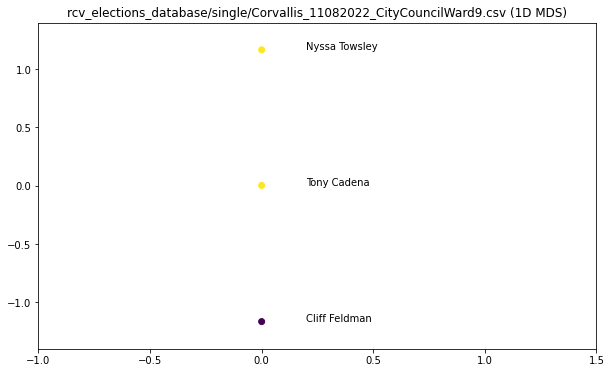

2D Inter-centroid distance for rcv_elections_database/single/Corvallis_11082022_CityCouncilWard9.csv: 1.5258638397180109


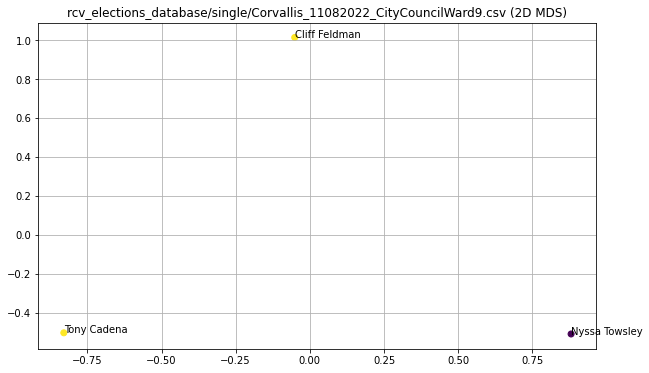

1D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict49.csv: 1.7497251681808006


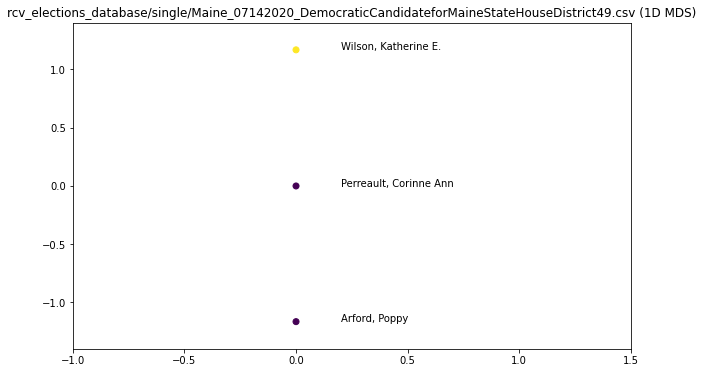

2D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict49.csv: 1.532581293442949


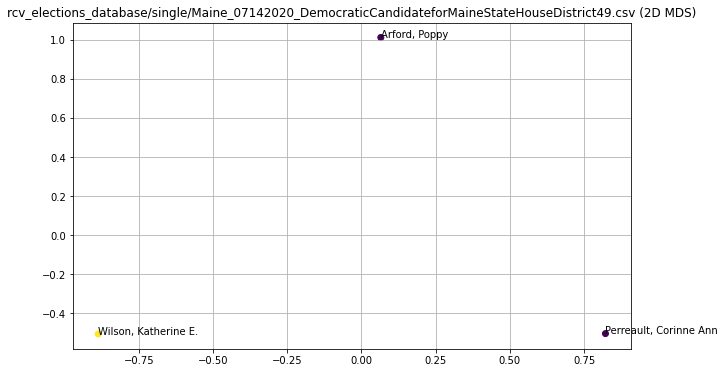

1D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict47.csv: 1.752893955444889


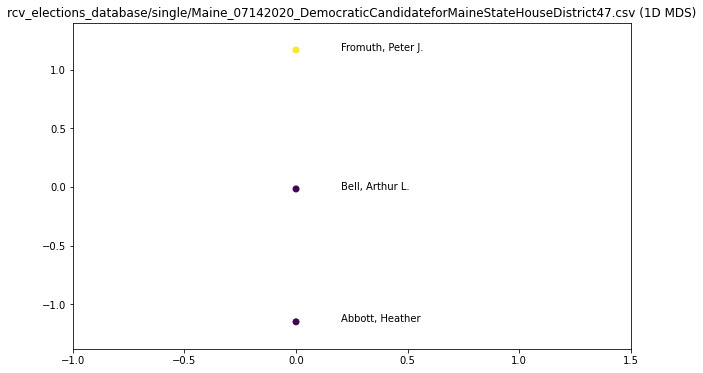

2D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict47.csv: 1.5296551453664538


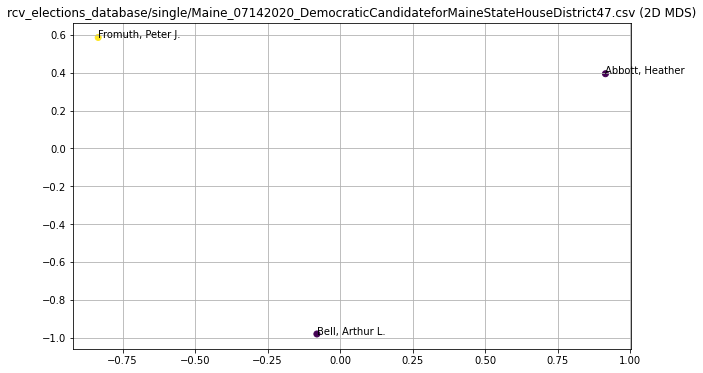

1D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict41.csv: 1.7541906842884387


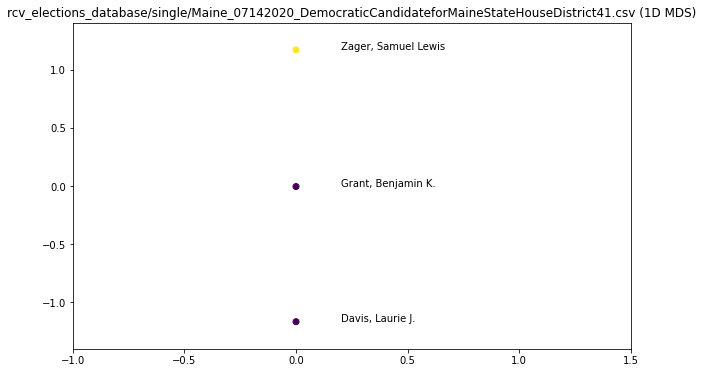

2D Inter-centroid distance for rcv_elections_database/single/Maine_07142020_DemocraticCandidateforMaineStateHouseDistrict41.csv: 1.53929185754541


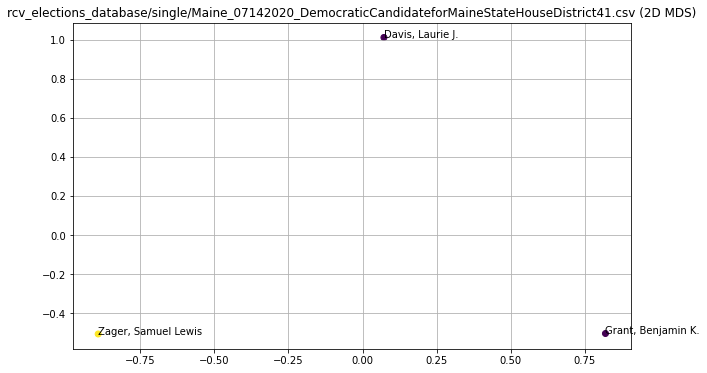

1D Inter-centroid distance for rcv_elections_database/single/Berkeley_11022010_CityCouncilDistrict7.csv: 1.755536449832146


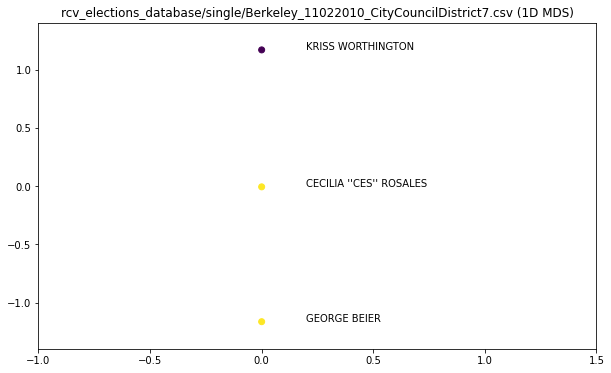

2D Inter-centroid distance for rcv_elections_database/single/Berkeley_11022010_CityCouncilDistrict7.csv: 1.5334256633936778


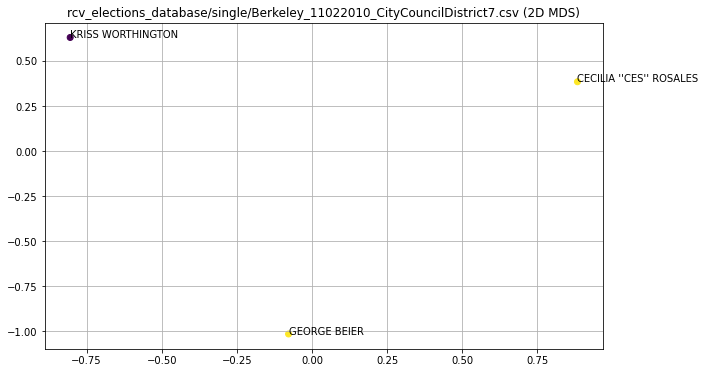

1D Inter-centroid distance for rcv_elections_database/single/SantaFe_03062018_CityCouncilDistrict4.csv: 1.7560617646419878


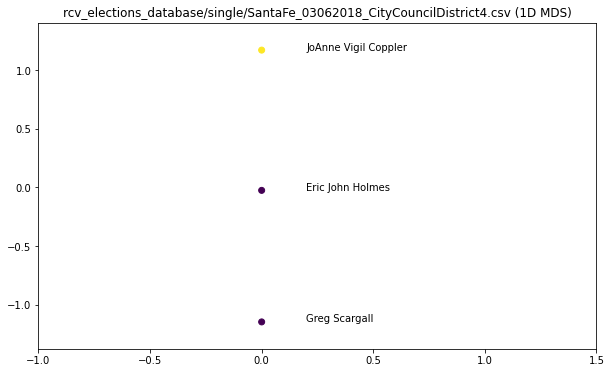

2D Inter-centroid distance for rcv_elections_database/single/SantaFe_03062018_CityCouncilDistrict4.csv: 1.536616400386288


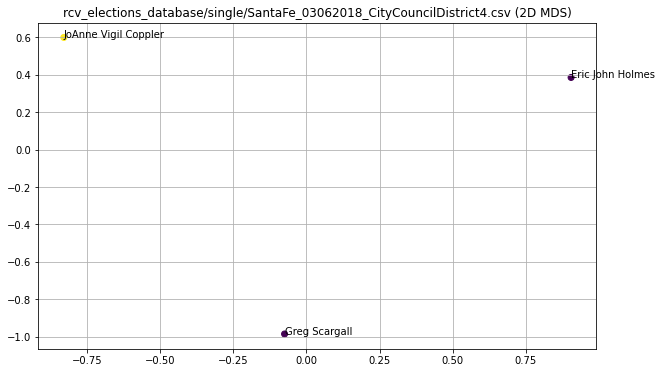

1D Inter-centroid distance for rcv_elections_database/single/LasCruces_11052019_COUNCILORPOSITION4CITYOFLASCRUCESDISTRICT4COUNCILOR.csv: 1.7576786267845739


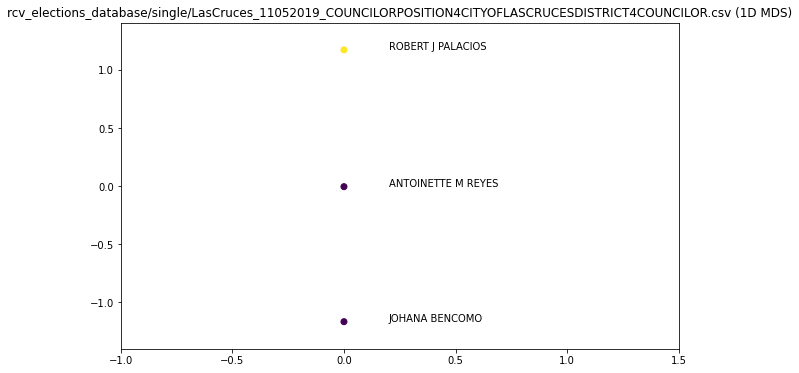

2D Inter-centroid distance for rcv_elections_database/single/LasCruces_11052019_COUNCILORPOSITION4CITYOFLASCRUCESDISTRICT4COUNCILOR.csv: 1.5375701694818746


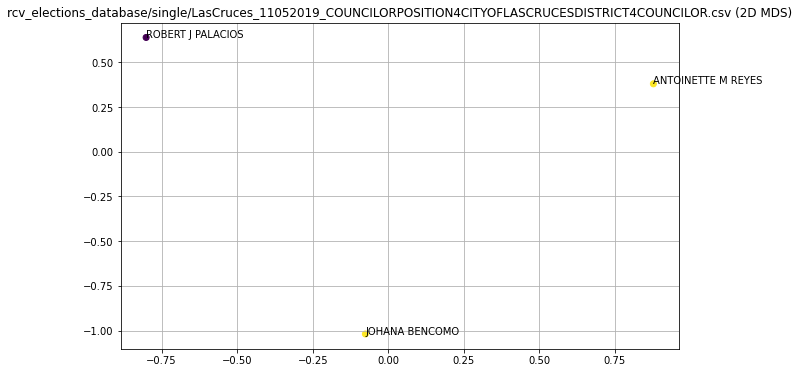

1D Inter-centroid distance for rcv_elections_database/single/Minneapolis_11022021_CityCouncilWard7.csv: 1.7589424775901705


In [60]:
import matplotlib.pyplot as plt

# Iterate over each result and create the plots
for result in sorted(results, key=lambda x: x['inter_centroid_distance_1d']):
    title = result['election']
    names = result['names']
    Ncand = len(names)

    # Check if there are more than 2 candidates
    if Ncand > 2:
        YY = result['1d_mds']
        Y = result['2d_mds']
        kmeans_1d_labels = result['kmeans_1d_labels']
        kmeans_2d_labels = result['kmeans_2d_labels']
        
        print(f'1D Inter-centroid distance for {title}:', result['inter_centroid_distance_1d'])

        # Plot 1D MDS with KMeans clustering
        plt.figure(figsize=(10, 6))
        plt.title(title + ' (1D MDS)')
        plt.scatter(np.zeros_like(YY), YY, c=kmeans_1d_labels)
        for i in range(Ncand):
            plt.text(0.2, YY[i], names[i])
        plt.axis([-1, 1.5, YY.min()*1.2, YY.max()*1.2])
        plt.show()

        print(f'2D Inter-centroid distance for {title}:', result['inter_centroid_distance_2d'])

        # Plot 2D MDS with KMeans clustering
        plt.figure(figsize=(10, 6))
        plt.title(title + ' (2D MDS)')
        plt.scatter(Y[:, 0], Y[:, 1], c=kmeans_2d_labels)
        for i in range(Ncand):
            plt.text(Y[i, 0], Y[i, 1], names[i])
        plt.grid(True)
        plt.show()

In [ ]:
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'Burlington_03072023_CityCouncilCentralDistrict.csv'].copy()

# Convert candidate names to numeric IDs for MDS
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform MDS
mds = MDS(n_components=2, metric=False, dissimilarity='euclidean')
mds_coordinates = mds.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(mds_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the MDS coordinates and color code them by cluster label
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'MDS plot for election Burlington_03072023_CityCouncilCentralDistrict.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'Burlington_03072023_CityCouncilCentralDistrict.csv'].copy()

# Convert candidate names to numeric IDs for PCA
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform PCA
pca = PCA(n_components=2)
pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(pca_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the PCA coordinates and color code them by cluster label
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'PCA plot for election Burlington_03072023_CityCouncilCentralDistrict.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

In [ ]:
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

inter_centroid_distances = []

# Number of elections to sample
n_samples = 50

# Randomly sample a subset of the elections
elections_sample = np.random.choice(cast_vote_data['source_file'].unique(), size=n_samples, replace=False)

# Iterate over the sampled elections
for election in elections_sample:
    # Filter DataFrame to include only the current election
    election_df = cast_vote_data[cast_vote_data['source_file'] == election].copy()

    # Convert candidate names to numeric IDs for MDS
    le = LabelEncoder()
    for col in election_df.columns:
        if col.startswith('rank'):
            # Handle missing values by replacing them with a placeholder
            election_df[col] = election_df[col].fillna('Missing')
            election_df[col] = le.fit_transform(election_df[col])

    # Perform MDS
    mds = MDS(n_components=2)
    mds_coordinates = mds.fit_transform(election_df.drop(columns=['source_file', 'type']))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
    kmeans.fit(pca_coordinates)

    # Compute the inter-centroid distance and store it
    centroid1, centroid2 = kmeans.cluster_centers_
    inter_centroid_distance = distance.euclidean(centroid1, centroid2)
    inter_centroid_distances.append(inter_centroid_distance)

    # Plot the MDS coordinates and color code them by cluster label
    plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans.labels_)
    plt.title(f'MDS plot for election {election}')
    plt.show()

# List of inter-centroid distances for the sampled elections, convert it to a pandas Series for easier manipulation
inter_centroid_distances = pd.Series(inter_centroid_distances, index=elections_sample)

# Reindex the inter_centroid_distances Series to match the order of the ballots_per_election Series
inter_centroid_distances = inter_centroid_distances.reindex(ballots_per_election.index)

# Plot the inter-centroid distances
inter_centroid_distances.plot(kind='barh', figsize=(10, 15))
plt.xlabel('Inter-centroid distance')
plt.ylabel('Election')
plt.title('Inter-centroid distances for each election')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

inter_centroid_distances = []

# Iterate over all elections
for election in cast_vote_data['source_file'].unique():
    # Filter DataFrame to include only the current election
    election_df = cast_vote_data[cast_vote_data['source_file'] == election].copy()

    # Convert candidate names to numeric IDs for PCA
    le = LabelEncoder()
    for col in election_df.columns:
        if col.startswith('rank'):
            # Handle missing values by replacing them with a placeholder
            election_df[col] = election_df[col].fillna('Missing')
            election_df[col] = le.fit_transform(election_df[col])

    # Perform PCA
    pca = PCA(n_components=2)
    pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
    kmeans.fit(pca_coordinates)

    # Compute the inter-centroid distance and store it
    centroid1, centroid2 = kmeans.cluster_centers_
    inter_centroid_distance = distance.euclidean(centroid1, centroid2)
    inter_centroid_distances.append((election, inter_centroid_distance))

# Create a DataFrame with inter-centroid distances for all elections
inter_centroid_df = pd.DataFrame(inter_centroid_distances, columns=['Election', 'Inter-centroid Distance'])
inter_centroid_df.set_index('Election', inplace=True)

# Sort the DataFrame by inter-centroid distance in descending order
sorted_inter_centroid_df = inter_centroid_df.sort_values(by='Inter-centroid Distance', ascending=False)

# Print the DataFrame
print(sorted_inter_centroid_df)

# Plot the inter-centroid distances
sorted_inter_centroid_df.plot(kind='barh', figsize=(10, 15), legend=False)
plt.xlabel('Inter-centroid Distance')
plt.ylabel('Election')
plt.title('Inter-centroid Distances for Each Election')
plt.show()

In [ ]:
# Print each row in the sorted DataFrame one by one
for idx, row in sorted_inter_centroid_df.iterrows():
    print(f"Election: {idx}, Inter-centroid Distance: {row['Inter-centroid Distance']}")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'TakomaPark_11082022_Mayor.csv'].copy()

# Convert candidate names to numeric IDs for PCA
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform PCA
pca = PCA(n_components=2)
pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(pca_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the PCA coordinates and color code them by cluster label
plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'PCA plot for election TakomaPark_11082022_Mayor.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

In [ ]:
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np

# Filter DataFrame to include only the current election
election_df = cast_vote_data[cast_vote_data['source_file'] == 'TakomaPark_11082022_Mayor.csv'].copy()

# Convert candidate names to numeric IDs for PCA
le = LabelEncoder()
for col in election_df.columns:
    if col.startswith('rank'):
        # Handle missing values by replacing them with a placeholder
        election_df[col] = election_df[col].fillna('Missing')
        election_df[col] = le.fit_transform(election_df[col])

# Perform MDS
mds = MDS(n_components=2)
mds_coordinates = mds.fit_transform(election_df.drop(columns=['source_file', 'type']))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
kmeans.fit(mds_coordinates)

# Compute the inter-centroid distance
centroid1, centroid2 = kmeans.cluster_centers_
inter_centroid_distance = euclidean(centroid1, centroid2)

# Plot the MDS coordinates and color code them by cluster label
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans.labels_)
plt.title(f'MDS plot for election TakomaPark_11082022_Mayor.csv')
plt.show()

print('Inter-centroid distance:', inter_centroid_distance)

In [ ]:
import matplotlib.pyplot as plt

# Count the number of ballots cast for each election
ballots_per_election = cast_vote_data['source_file'].value_counts().sort_values()

# Plot the data
plt.figure(figsize=(10, 15))
ballots_per_election.plot(kind='barh')
plt.xlabel('Number of ballots cast')
plt.ylabel('Election')
plt.title('Number of ballots cast in each election')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np

inter_centroid_distances = []

# Number of elections to sample
n_samples = 50

# Randomly sample a subset of the elections
elections_sample = np.random.choice(cast_vote_data['source_file'].unique(), size=n_samples, replace=False)

# Iterate over the sampled elections
for election in elections_sample:
    # Filter DataFrame to include only the current election
    election_df = cast_vote_data[cast_vote_data['source_file'] == election].copy()

    # Convert candidate names to numeric IDs for PCA
    le = LabelEncoder()
    for col in election_df.columns:
        if col.startswith('rank'):
            # Handle missing values by replacing them with a placeholder
            election_df[col] = election_df[col].fillna('Missing')
            election_df[col] = le.fit_transform(election_df[col])

    # Perform PCA
    pca = PCA(n_components=2)
    pca_coordinates = pca.fit_transform(election_df.drop(columns=['source_file', 'type']))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=2)  # assuming two clusters; adjust as needed
    kmeans.fit(pca_coordinates)

    # Compute the inter-centroid distance and store it
    centroid1, centroid2 = kmeans.cluster_centers_
    inter_centroid_distance = distance.euclidean(centroid1, centroid2)
    inter_centroid_distances.append(inter_centroid_distance)

    # Plot the PCA coordinates and color code them by cluster label
    plt.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=kmeans.labels_)
    plt.title(f'PCA plot for election {election}')
    plt.show()

# List of inter-centroid distances for the sampled elections, convert it to a pandas Series for easier manipulation
inter_centroid_distances = pd.Series(inter_centroid_distances, index=elections_sample)

# Reindex the inter_centroid_distances Series to match the order of the ballots_per_election Series
inter_centroid_distances = inter_centroid_distances.reindex(ballots_per_election.index)

# Plot the inter-centroid distances
inter_centroid_distances.plot(kind='barh', figsize=(10, 15))
plt.xlabel('Inter-centroid distance')
plt.ylabel('Election')
plt.title('Inter-centroid distances for each election')
plt.show()